# 1. Confusion Matrix 작성 실습

sklearn과 matplotlib을 사용하여
confusion matrix를 행렬형식으로 작성하고, 시각화시키는 법을 알아본다.


몇가지 라이브러리 설명

- scipy & numpy : 계산, 데이터 분석 모듈(주로 행렬 분석을 위해 사용)
- matplotlib : 데이터 시각화 라이브러리. MATLAB에서와 같은 방식으로 python에서 거의 비슷한 함수로 사용할 수 있게 해줌
- sklearn : 사이킷런. 다양한 도구(SVM 등의 기계학습 모델, PCA 같은 차원 축소 모델, ...) 지원

sklearn 설치를 위해서는 scikit-learn 설치가 필요하다.
일반 작업환경에서 (pip install -U scikit-learn)
혹은 Anaconda에서 (conda install scikit-learn) 으로 설치 가능. <-- 이걸 추천.

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.    0.62  0.38]
 [ 0.    0.    1.  ]]


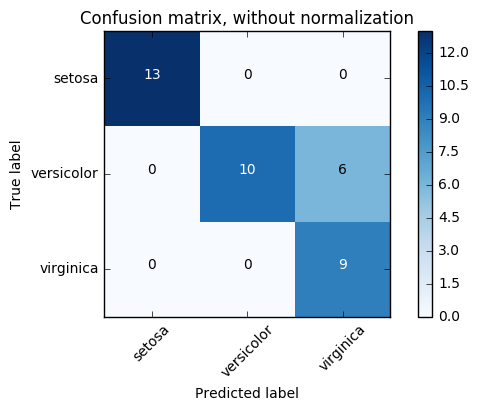

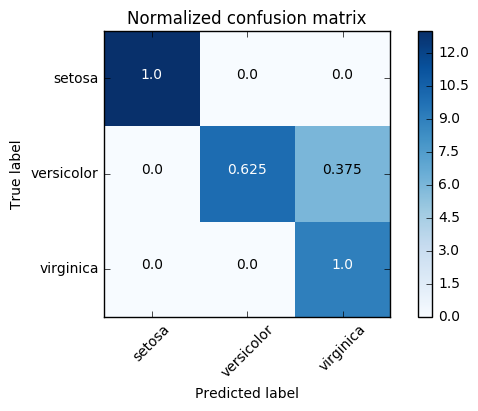

In [101]:
import itertools
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 분석을 위해 iris 데이터를 불러온다.
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# iris data를 training set과 test set으로 분리한다. test 비율 = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# SVM을 사용해서 분류 모델 작성한다.(C=0.01로 작은 값을 사용)
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


# confusion matrix 작성 & 시각화
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Confusion Matrix를 정규화시켜서 표현할 건지를 결정한다.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# sklearn에서 제공하는 confusion_matrix 함수를 사용하여 confusion matrix를 작성한다.
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2) # 소수점 자리 2자리까지로 제한.

# Non-normalized confusion matrix를 그려본다.
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Normalized confusion matrix를 그려본다.
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# 2. ROC Curve 작성 실습

예측 모델에 대해 ROC Curve를 그리고, AUC를 구해본다.

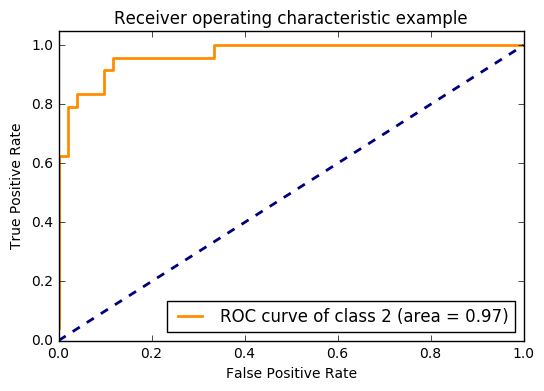

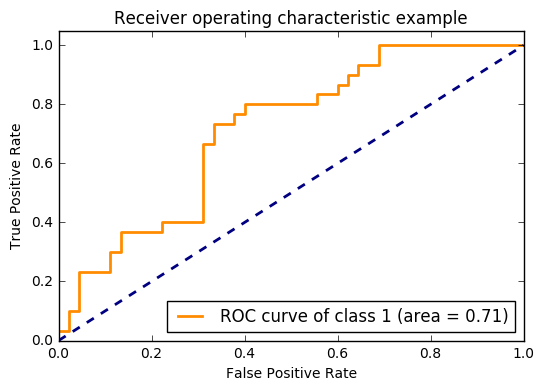

In [102]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

random_state = np.random.RandomState(0)
# Confusion Matrix 에서와 같은 iris 데이터 사용. 3-class 데이터이다.
iris = datasets.load_iris()
X = iris.data
y = iris.target

# multi-class problem이기 때문에 분석을 위해 타겟 y를 행렬 형태로 변환한다.
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]


# 데이터를 Training set과 Test set으로 구분한다. test 비율 = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# SVM으로 모델링을 하는데, 각 class에 대한 예측을 따로 수행하는 classifier를 만든다.
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=0.01, probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test) # X_test와 hyperplane까지의 거리 계산


# 각 class에 대해 ROC curve를 그리고, AUC를 계산한다.
def plot_roc_curve(n_classes, target_class, y_test, y_score) :

    # ROC Curve를 그리기 위해 ROC 값을 계산하고, 전체 AUC를 구한다.
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 위에서 구한 ROC 값을 이용하여 ROC Curve를 그린다.
    plt.figure()
    lw = 2
    plt.plot(fpr[target_class], tpr[target_class], color='darkorange',
             lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(target_class, roc_auc[target_class]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    

# class 1, 2에 대하여 ROC Curve를 작성해본다.

plot_roc_curve(n_classes = n_classes, target_class=2, y_test = y_test, y_score = y_score)
plot_roc_curve(n_classes = n_classes, target_class=1, y_test = y_test, y_score = y_score)



# 3. K-Fold Cross Validation 실습

- K-fold Cross Validation : 데이터를 k개로 분할해 (k-1)개를 training set, 나머지 1개를 test set로 하는 평가를 k번 반복하여 모델을 평가한다.

주어진 data에 대해 k-fold cross validation을 적용하는 방법을 알아보고, 이를 사용해 ROC Curve를 그려본다.

In [103]:
# 주어진 데이터에 K-Fold를 간단히 적용시켜본다.

from sklearn.model_selection import KFold

Dset = ["a", "b", "c", "d", "e"]
kf = KFold(n_splits=5)
for train, test in kf.split(Dset) :
    print("%s %s" % (train, test))
    
    


[1 2 3 4] [0]
[0 2 3 4] [1]
[0 1 3 4] [2]
[0 1 2 4] [3]
[0 1 2 3] [4]


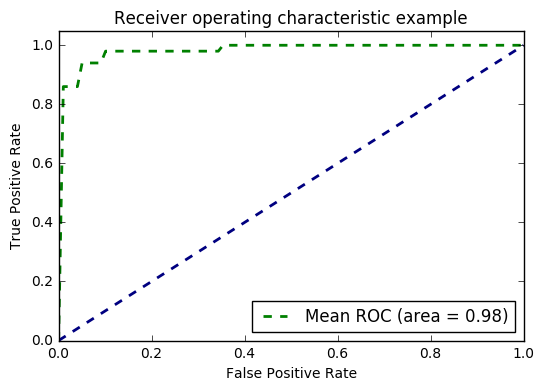

In [104]:
# 층화 K-Fold를 사용하여 평균적인 성능을 측정하는 ROC Curve를 그려본다.

# iris 데이터는 0이 적은 편으로, 층화 K-Fold를 사용하여 비율을 조정하여 준다.
from sklearn.model_selection import StratifiedKFold

# 앞의 2. ROC Curve 실습 에서와 거의 같은 방식으로 진행된다.
iris = datasets.load_iris()
X = iris.data
y = iris.target

n_classes = 3
n_splits = 5 # K = 5로 설정하였다.

cv = StratifiedKFold(n_splits = n_splits)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=0.01, probability=True,
                                 random_state=0))

# K-Fold를 통해 평균적인 ROC Curve를 그리려 하므로, 평균 tpr, fpr, auc를 저장할 변수를 딕셔너리 형태로 만들어준다.
# 여기서 평균 fpr은 사실상 무의미하고, 그래프를 그리려는 목적으로만 생성하였다.
mean_tpr = dict()
mean_fpr = np.linspace(0,1,100) # mean_fpr[0, 0.01, 0.02, ..., 0.99, 1] 과 같은 형태가 된다.
mean_auc = dict()

# mean_tpr을 초기화시켜준다.
for cnt in range(n_classes) :
    mean_tpr[cnt] = 0.0

# K-Fold를 통해 나눈 데이터 셋에 대해 평균적인 tpr, fpr을 계산하여 준다.    
for (train, test) in cv.split(X, y) :
    # 앞의 2. ROC Curve 실습에서는 이 과정을 처음 X, y 설정부분에서 해주었는데, 
    # StratifiedKFold는 matrix 형태의 y를 받지 않아 for문 안쪽에서 진행하였다.
    y = label_binarize(y, classes=[0, 1, 2]) 
    y_score = classifier.fit(X[train], y[train]).decision_function(X[test])
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[test][:, i], y_score[:, i])
        mean_tpr[i] += interp(mean_fpr, fpr[i], tpr[i]) # 보간법을 사용하여 tpr값을 추정하여준다.
        mean_tpr[i][0] = 0.0

for cnt in range(n_classes) :
    mean_tpr[cnt] /= n_splits # 앞서 mean_tpr은 tpr을 다 더해준 형태이므로, 평균으로 바꿔주기 위해 K로 나눠준다.
    mean_tpr[cnt][-1] = 1.0
    mean_auc[cnt] = auc(mean_fpr, mean_tpr[cnt])

target_class = 2    
lw = 2

plt.plot(mean_fpr, mean_tpr[target_class], color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc[target_class], lw=lw)
        
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
